In [15]:
import pandas as pd
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
import seaborn as sns
import statistics as stats
import warnings


warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize']=10,10
plt.style.use("ggplot")

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

Data : heart.csv

In [2]:
Df=pd.read_csv("heart.csv")
Df.head(5)

,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium,Heart Disease
0,70,1,4,130,322,0,2,109,0,2.4,2,3,3,Presence
1,67,0,3,115,564,0,2,160,0,1.6,2,0,7,Absence
2,57,1,2,124,261,0,0,141,0,0.3,1,0,7,Presence
3,64,1,4,128,263,0,0,105,1,0.2,2,1,7,Absence
4,74,0,2,120,269,0,2,121,1,0.2,1,1,3,Absence


In [3]:
Df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270 entries, 0 to 269
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      270 non-null    int64  
 1   Sex                      270 non-null    int64  
 2   Chest pain type          270 non-null    int64  
 3   BP                       270 non-null    int64  
 4   Cholesterol              270 non-null    int64  
 5   FBS over 120             270 non-null    int64  
 6   EKG results              270 non-null    int64  
 7   Max HR                   270 non-null    int64  
 8   Exercise angina          270 non-null    int64  
 9   ST depression            270 non-null    float64
 10  Slope of ST              270 non-null    int64  
 11  Number of vessels fluro  270 non-null    int64  
 12  Thallium                 270 non-null    int64  
 13  Heart Disease            270 non-null    object 
dtypes: float64(1), int64(12), 

# Data Preprocessing :

In [4]:
X=Df
X['Heart Disease'].replace('Presence',1,inplace=True)
X['Heart Disease'].replace('Absence',-1,inplace=True)

y=Df['Heart Disease']
y1=y.copy(deep=True)
X=X.drop(columns='Heart Disease')


print('x-shape : {}\n'.format(X.shape))
print('y-shape : {}\n'.format(y.shape))

features_names=[i for i in X.columns]
target_name='Heart Disease'

y1.replace(-1,0,inplace=True)

x-shape : (270, 13)

y-shape : (270,)



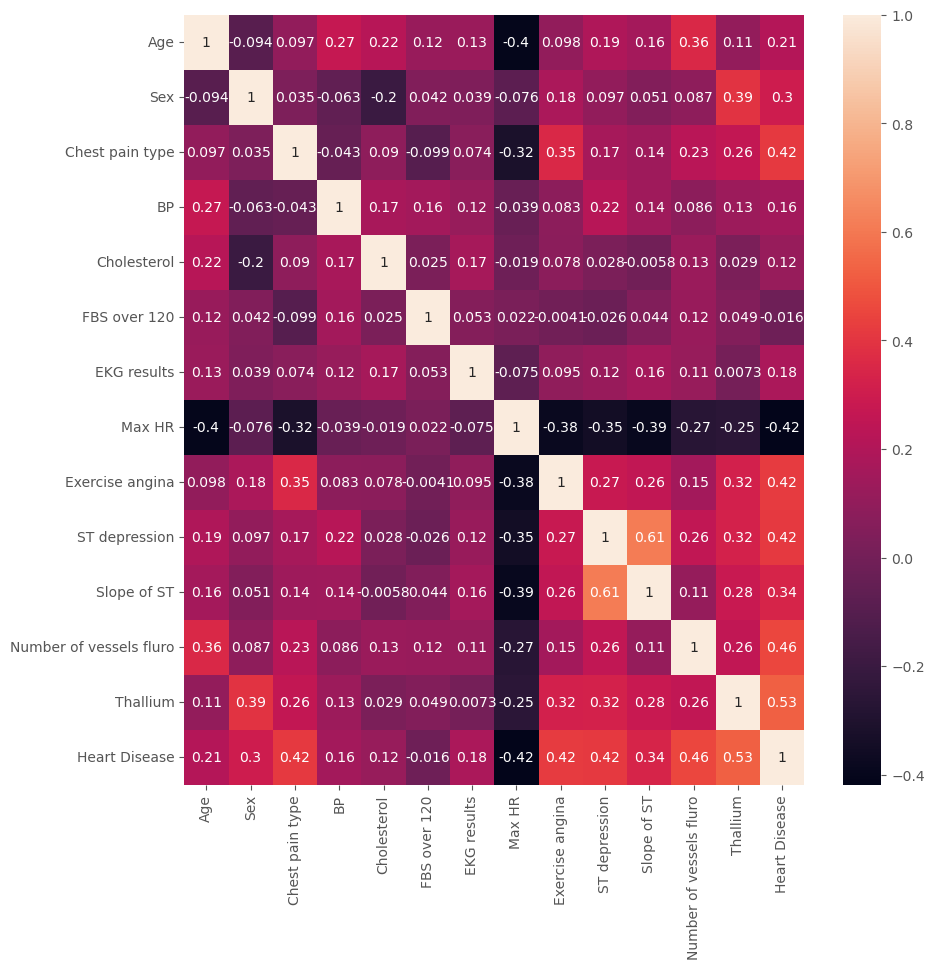

In [5]:
sns.heatmap(data=Df.corr(),annot=True)
plt.show()

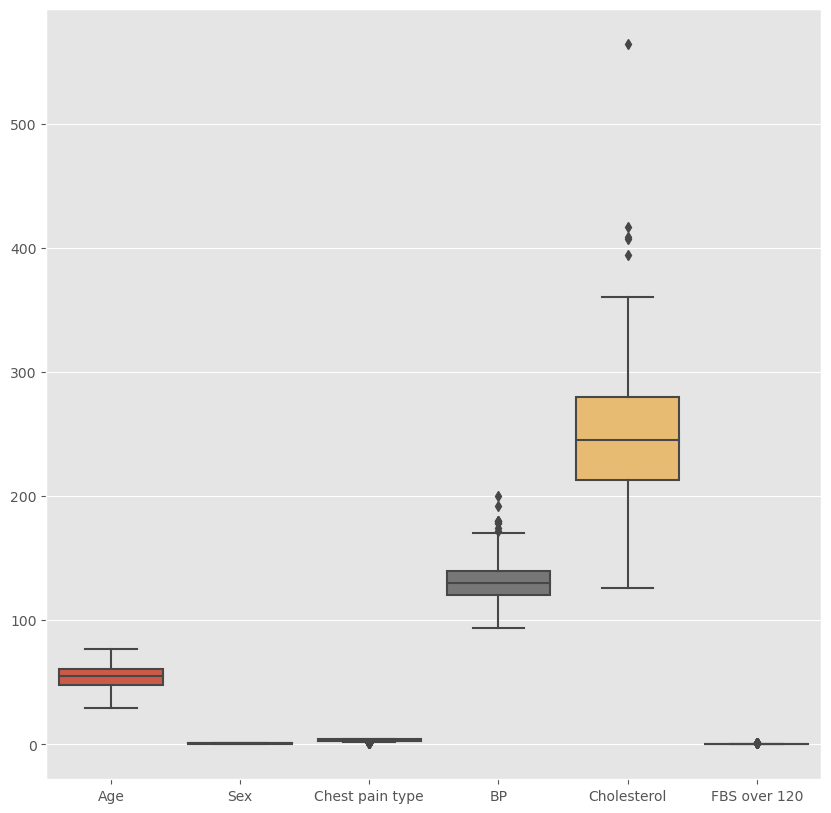

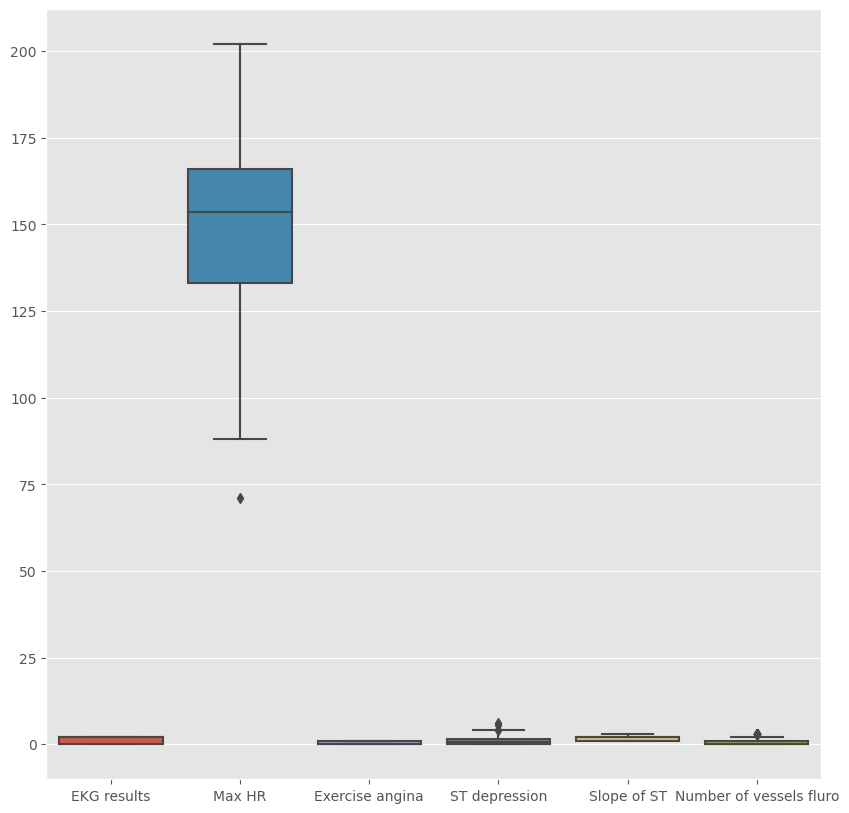

In [6]:
sns.boxplot(data=X.iloc[:,0:6])
plt.show()

sns.boxplot(data=X.iloc[:,6:12])
plt.show()

Feature Scaling

In [7]:
from sklearn.preprocessing import RobustScaler as RS
scaler=RS()
X=scaler.fit_transform(X)
X=pd.DataFrame(data=X, columns=features_names)
X.head()

,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium
0,1.153846,0.0,1.0,0.00,1.149254,0.0,0.0,-1.348485,0.0,1.0000,0.0,3.0,0.0
1,0.923077,-1.0,0.0,-0.75,4.761194,0.0,0.0,0.196970,0.0,0.5000,0.0,0.0,1.0
2,0.153846,0.0,-1.0,-0.30,0.238806,0.0,-1.0,-0.378788,0.0,-0.3125,-1.0,0.0,1.0
3,0.692308,0.0,1.0,-0.10,0.268657,0.0,-1.0,-1.469697,1.0,-0.3750,0.0,1.0,1.0
4,1.461538,-1.0,-1.0,-0.50,0.358209,0.0,0.0,-0.984848,1.0,-0.3750,-1.0,1.0,0.0


# SVM :

In [8]:
class SVM:
    def __init__(self):
        self.x=None
        self.y=None
        self.feature_names=None
        self.target_name=None
        self.w=None
        self.r=None
        self.psi=None
        
    def fit(self,X,y):
        if isinstance(X,pd.DataFrame): 
            self.feature_names = [f for f in X.columns]
            self.x=np.array(X)
        else:
            self.x=X
        if isinstance(y,pd.DataFrame): 
            self.target_names = [f for f in y.columns]
            self.y=np.array(y).reshape(-1,1)
        else:
            self.y=y
        self.w,self.r,self.psi=self._optimization(self.x,self.y,0.1)
            
    def _optimization(self,x,y,c):
        xrows=len(x)
        xcols=x.shape[1]
        D=np.diag(y)
        E=np.ones(xrows)
        W=cp.Variable(xcols)
        r=cp.Variable(1)
        psi=cp.Variable(xrows)
        obj=cp.Minimize(0.5*cp.norm(W)**2 + c*cp.sum(psi))
        constraints=[cp.matmul(D, x*W-r*E)+psi >=E , psi >= 0]
        opt=cp.Problem(obj, constraints)
        opt.solve()
        W=np.array(W.value)
        r=r.value
        psi=np.array(psi.value)
        return W,r,psi
    
    def _prediction(self,x):
        x=x.reshape(x.shape[0],1)
        p=(np.matmul(self.w,x) - self.r)
        if p>0:
            return 1
        elif p<0:
            return -1
        
    def predict(self,x):
        ypred=[]
        x=np.array(x)
        for i in range(0,x.shape[0]):
            ypred.append(self._prediction(x[i,:]))
        return ypred

In [9]:
xtrain,xtest,ytrain,ytest=train_test_split(X,y,test_size=0.2,random_state=72)
svm_model=SVM()
svm_model.fit(xtrain,ytrain)
yp=svm_model.predict(xtest)

acc1=accuracy_score(ytest,yp)
print("Accuracy_score : {}".format(acc1))
print("\nClassification_report : \n")
print(classification_report(ytest,yp))
print("Confusion_Matrix : \n")
print(confusion_matrix(ytest,yp))

Accuracy_score : 0.9444444444444444

Classification_report : 

              precision    recall  f1-score   support

          -1       0.93      0.97      0.95        29
           1       0.96      0.92      0.94        25

    accuracy                           0.94        54
   macro avg       0.95      0.94      0.94        54
weighted avg       0.94      0.94      0.94        54

Confusion_Matrix : 

[[28  1]
 [ 2 23]]


# KNN :

In [10]:
import numpy as np
import pandas as pd
import statistics as stats

def distance (x,p): 
        l=list(map(lambda x,y:(x-y)**2,x,p))
        return np.sqrt(sum(l))

class KNearestNeighbours : 
    def __init__(self,n_neighbors=5): 
        self.n_neighbors=n_neighbors 
        self.feature_names=[]
        self.target_names=[]
        self.num_sampels=0
        self.x=0
        self.y=0
        self.predicted_values=0

    def fit(self,x,y): 
        if isinstance(x,pd.DataFrame): 
            self.feature_names = [f for f in x.columns]
            self.x=np.array(x)
        else:
            self.x=x 
        if isinstance(y,pd.DataFrame): 
            self.target_names = [f for f in y.columns]
            self.y=np.array(y).reshape(-1)
        else:
            self.y=y 
        self.num_sampels=len(x)
        
    def predict(self, p): 
        predict_values=[] 
        p=np.array(p) 
        for i in p: 
            p = dict(sorted(self._predictions(i).items())[0:self.n_neighbors]) 
            predict_values.append(stats.mode(p.values())) 
        self.predicted_values=predict_values
        return predict_values

    def _predictions(self,p):
        d=dict()
        for x,y in zip(self.x,self.y):
            dis=distance(x,p)
            d.update({dis:y})
        return d
    

In [11]:
xtrain2,xtest2,ytrain2,ytest2=train_test_split(X,y,test_size=0.2,random_state=90)
knn_model=KNearestNeighbours(3)
knn_model.fit(xtrain2,ytrain2)

yp2=knn_model.predict(xtest2)
acc2=accuracy_score(ytest2,yp2)
print("accuracy_score : ",acc2,"\n")
print("\nClassification_report : \n")
print(classification_report(ytest2,yp2))
print("Confusion_Matrix : \n")
print(confusion_matrix(ytest2,yp2))

accuracy_score :  0.8333333333333334 


Classification_report : 

              precision    recall  f1-score   support

          -1       0.81      0.85      0.83        26
           1       0.85      0.82      0.84        28

    accuracy                           0.83        54
   macro avg       0.83      0.83      0.83        54
weighted avg       0.83      0.83      0.83        54

Confusion_Matrix : 

[[22  4]
 [ 5 23]]


# Logistic Regression :

In [12]:
class LogisticRegression:
    def __init__(self,iterations=1000,learning_rate=0.001):
        self.iterations=iterations
        self.lr=learning_rate
        self.feature_names=[]
        self.target_names=[]
        self.num_samples=0
        self.num_features=0
        self.x=0
        self.y=0
        self.tn=0
        self.t0=0
        
    def fit(self,x,y):
        if isinstance(x,pd.DataFrame): 
            self.feature_names = [f for f in x.columns]
            self.x=np.array(x)
        else:
            self.x=x 
        if isinstance(y,pd.DataFrame): 
            self.target_names = [f for f in y.columns]
            self.y=np.array(y).reshape(-1)
        else:
            self.y=y 
        self.num_samples=len(x)
        self.num_features=x.shape[1]
        
        self.tn=np.zeros(self.num_features)
        
        for i in range(self.iterations):
            LR=np.dot(self.x, self.tn) + self.t0
            ht=self._sigmoid_function(LR)
            gtn,gt0=self._updations(ht,self.tn,self.t0)
            self.tn-=self.lr*gtn
            self.t0-=self.lr*gt0
        
    def _updations(self,ht,tn,t0):
        gtn=np.dot(self.x.T, (ht-self.y))
        gtn=(1/self.num_samples)*gtn
        gt0=np.sum(ht-self.y)
        gt0=(1/self.num_samples)*gt0
        return gtn,gt0
        
    def _sigmoid_function(self,x):
        output=1/(1+(np.exp(-x)))
        return output
    
    def _prediction(self,x):
        l=np.dot(x, self.tn) + self.t0
        h=self._sigmoid_function(l)
        if h>0.5:
            return 1
        elif h<0.5:
            return 0
    def predict(self,x):
        predicted_values=[]
        x=np.array(x)
        for i in x:
            predicted_values.append(self._prediction(i))
        return predicted_values

In [13]:
xtrain3,xtest3,ytrain3,ytest3=train_test_split(X,y1,test_size=0.2,random_state=72)
lr_model=LogisticRegression(iterations=1500)
lr_model.fit(xtrain3,ytrain3)
yp3=lr_model.predict(xtest3)

acc3=accuracy_score(ytest3,yp3)
print("Accuracy_score : {}".format(acc3))
print("\nClassification_report : \n")
print(classification_report(ytest3,yp3))
print("Confusion_Matrix : \n")
print(confusion_matrix(ytest3,yp3))

Accuracy_score : 0.9074074074074074

Classification_report : 

              precision    recall  f1-score   support

           0       0.93      0.90      0.91        29
           1       0.88      0.92      0.90        25

    accuracy                           0.91        54
   macro avg       0.91      0.91      0.91        54
weighted avg       0.91      0.91      0.91        54

Confusion_Matrix : 

[[26  3]
 [ 2 23]]


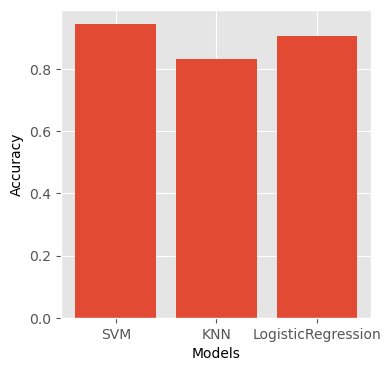

In [18]:

acc=[acc1,acc2,acc3]
models=['SVM','KNN','LogisticRegression']
plt.figure(figsize=(4, 4))
plt.bar(models,acc)
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.show()